# House Prices - Regression Predictions YData 2024
Team: AcadEMY

Team mates: Eran T, Maya L, Yair BH, Adir Golan.

In [18]:
# Imports
from utils import load_house_prices_data
from utils import calc_num_missing_vals_per_col, np
from plot_utils import plot_num_missing_values
from plot_utils import plot_price_dist_per_year
from plot_utils import plot_column_histograms
from plot_utils import plot_numeric_features_correlation_to_target
from plot_utils import plot_head_and_tail_categorical_corr_to_target
from utils import calc_categorical_feature_correlation_to_target
from utils import calc_numeric_feature_correlation
from plot_utils import plot_mean_price_and_stddev_per_category
from preprocessing import preprocess
from plot_utils import plot_number_of_sales_and_prices_across_time

## Part 1 - EDA

In [19]:
train_origin_df = load_house_prices_data('train')
train_features = train_origin_df.drop('SalePrice', axis='columns')

### 1.1 Which 3 features have the highest number of missing values?

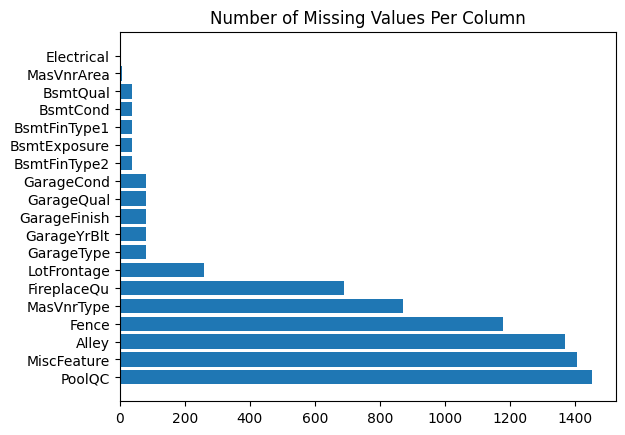

Top 3 features with the most missing values: ['PoolQC' 'MiscFeature' 'Alley']


In [20]:
num_of_nans = calc_num_missing_vals_per_col(train_features)

plot_num_missing_values(num_of_nans)

max_nans = num_of_nans.nlargest(3).index
print(f"Top 3 features with the most missing values: {max_nans.values}")

### 1.2 How does the price behave over the years?

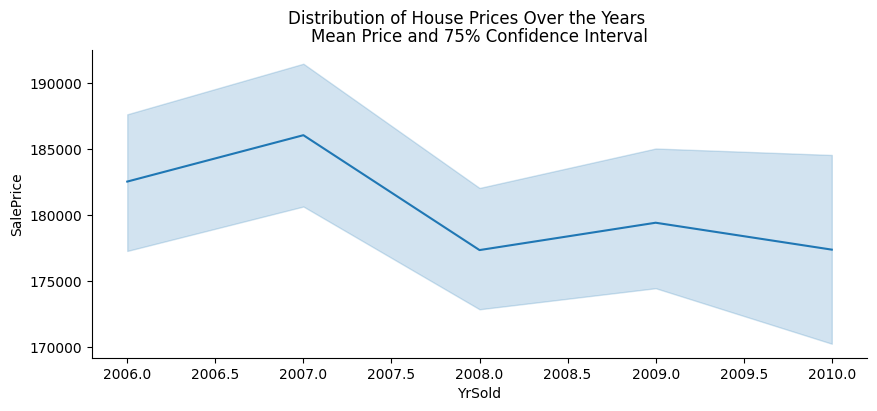

In [21]:
plot_price_dist_per_year(train_origin_df)

Graph Insight:
Over the 4 years shown, the mean price have fluctuated; increasing until 2007, with a down movement overall.

### 1.3 Plotting feature distribution using histograms

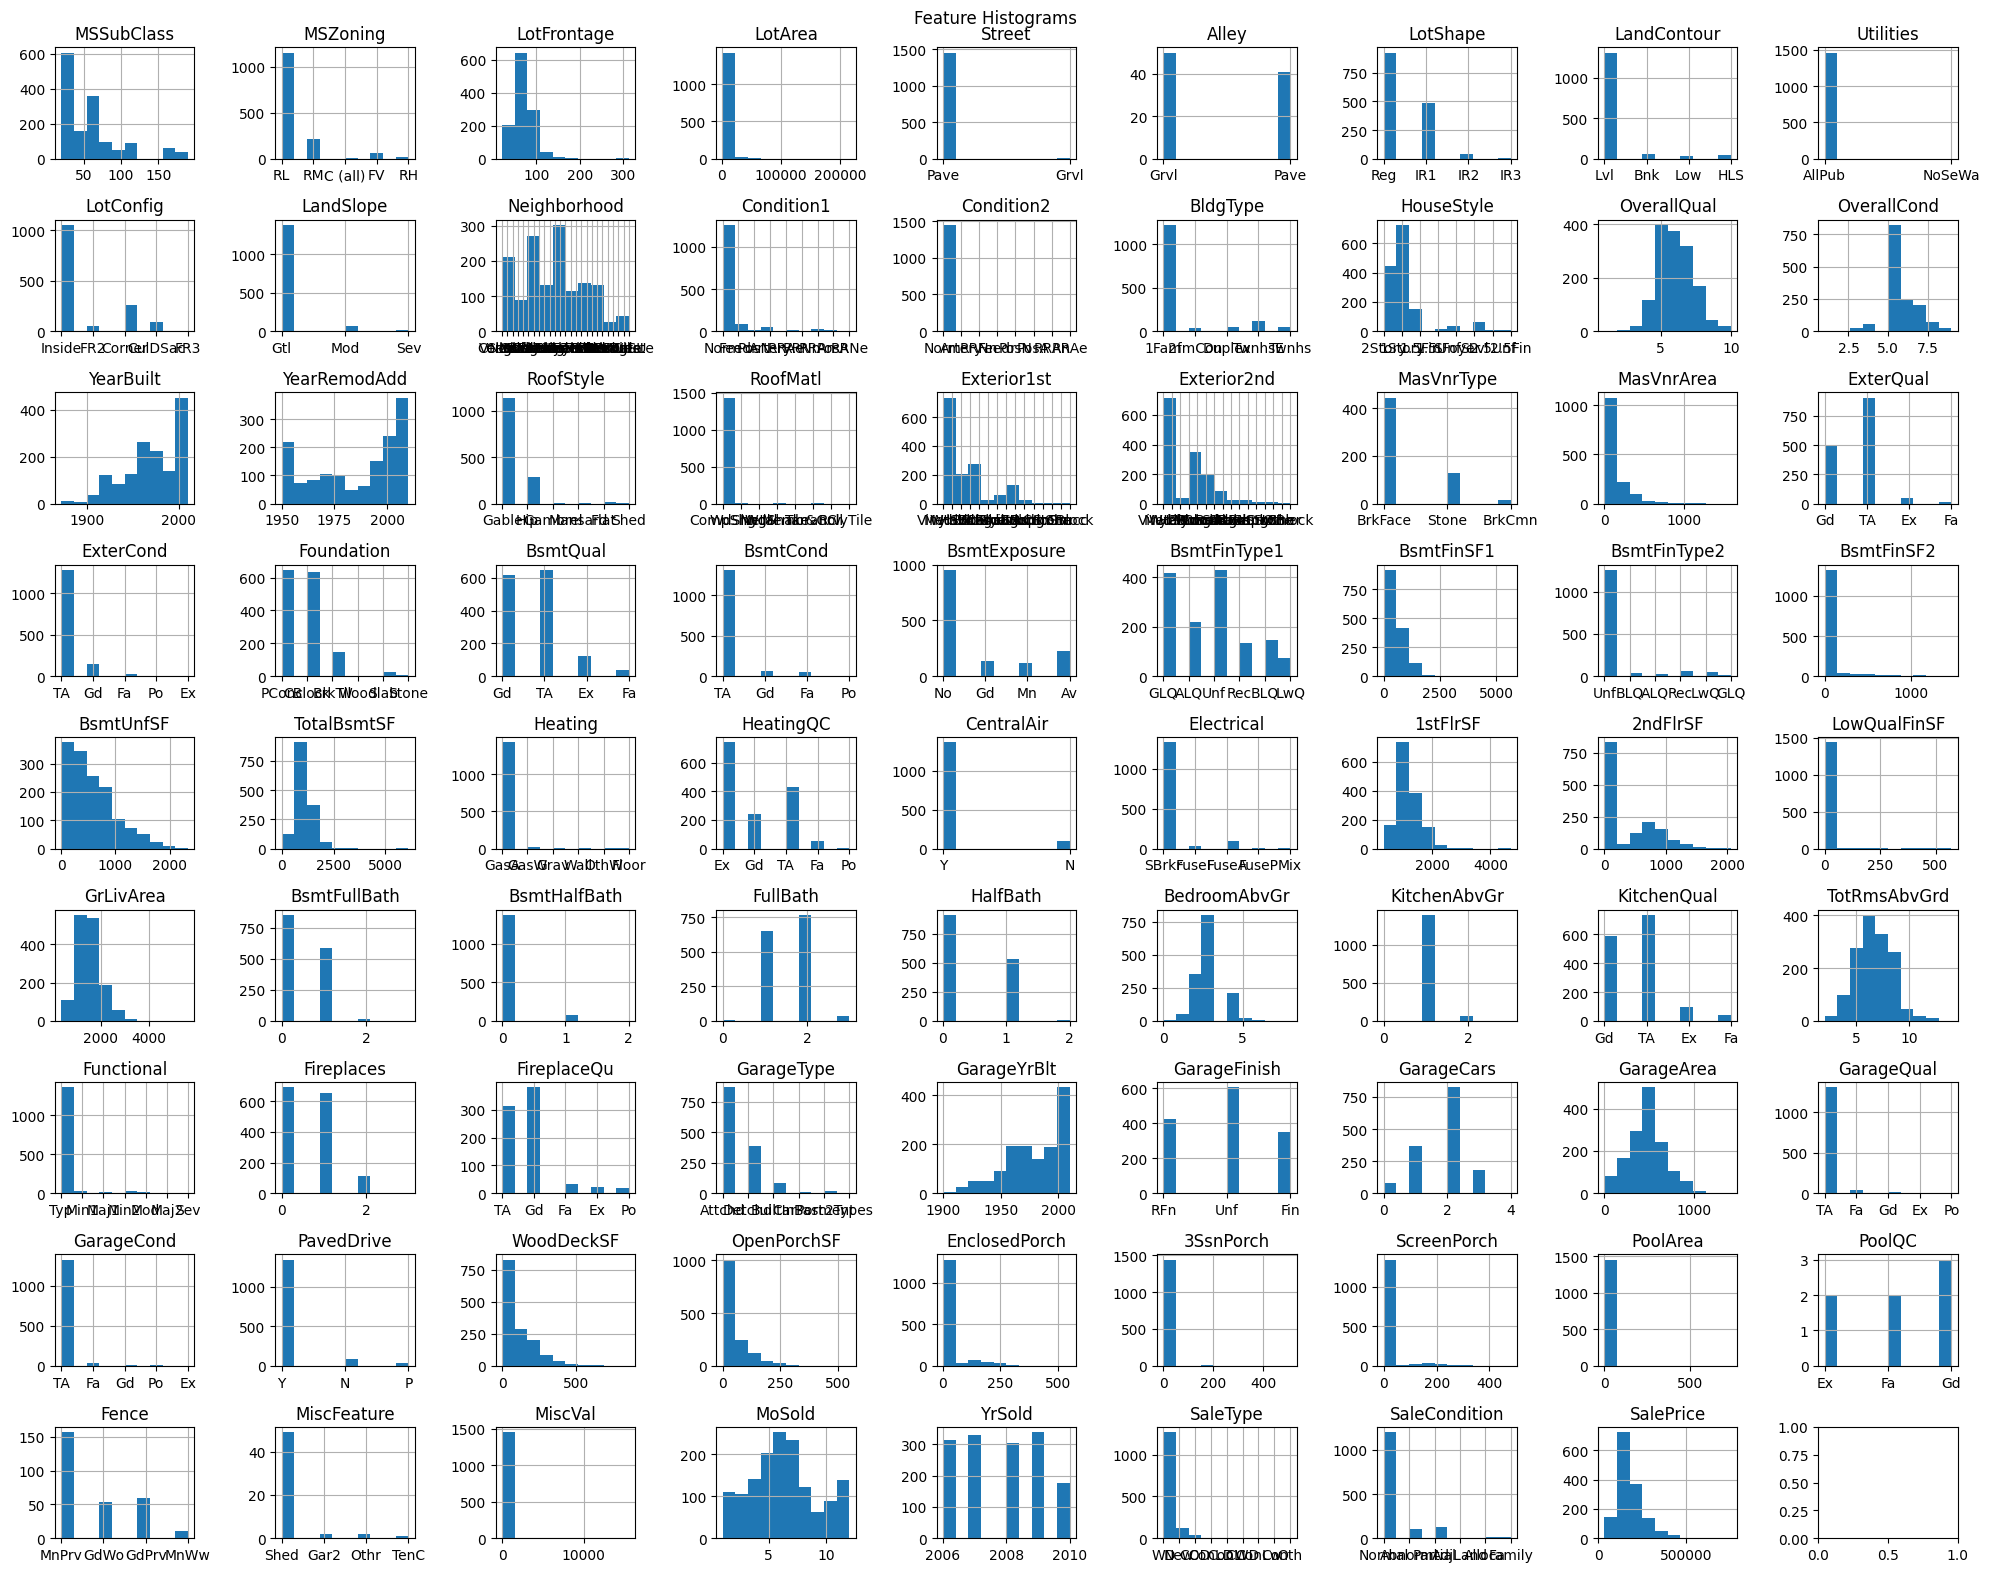

In [22]:
plot_column_histograms(train_origin_df)

Graph insights:
- Many unbalanced categorical features, including "SaleType","GarageCond","PavedDrive","Street".
- Some numerical feature resemble a normal distribution: "OverallQual","TotRmsAbvGrd", "GarageArea".
- There is a consistent increase in the number of houses built per year.
- There is seasonality in the month sold - most sales happen in summer (June, July) and least happen in winter (September, October).

### 1.4 Computing Feature Correlation to Label

#### Numeric Features

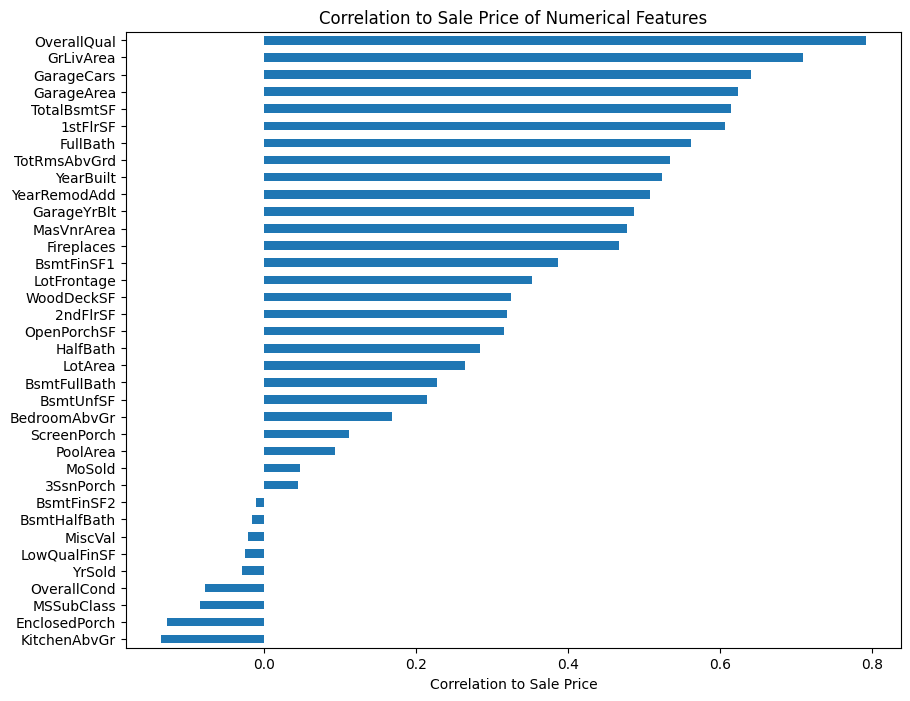

In [23]:
corr_vector = train_origin_df.select_dtypes(include='number').corr()['SalePrice'].sort_values().drop('SalePrice', axis=0)

plot_numeric_features_correlation_to_target(corr_vector)

Graph insights:
- The number of kitchens above ground has the most negative correlation to the house price.
- "BsmtFinSF2" has little to no correlation to the price.
- "OverallQual" has the highest positive correlation, while "OverallCond" has somewhat negative correlation, meaning physical condition matters less than subjective measures.
- The top 5 features correlated to price mean that people value quality, area of living and garage space. 

#### Categorical Features

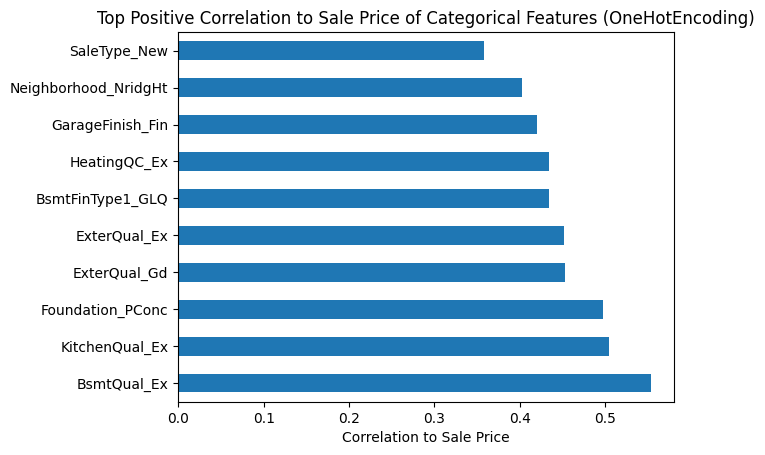

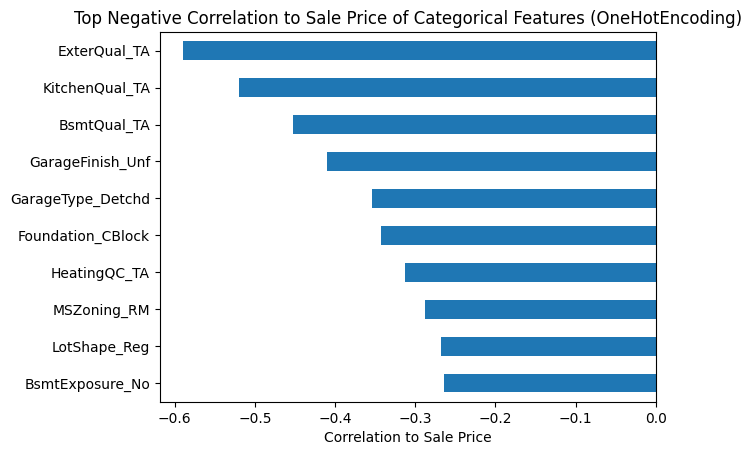

In [24]:
sorted_correlation = calc_categorical_feature_correlation_to_target(train_origin_df)

plot_head_and_tail_categorical_corr_to_target(sorted_correlation)

### 1.5 More EDA that will help us understand the data and support our modelling decisions

#### Feature selection (searching features that can be dropped)
The idea is that due to the large number of features in the original dataset (80, not including the target), it might be beneficial to reduce the number of features. We do this in different ways:

##### Highly correlated numerical features
We looked for highly correlated features and decided to drop one of each pair:

In [25]:
numeric_correlations = calc_numeric_feature_correlation(train_features)
threshold = 0.7
highly_correlated_numeric_features = [t for t in numeric_correlations if t[2] >= threshold]

print(highly_correlated_numeric_features)

[('YearBuilt', 'GarageYrBlt', 0.826), ('TotalBsmtSF', '1stFlrSF', 0.82), ('GrLivArea', 'TotRmsAbvGrd', 0.825), ('GarageCars', 'GarageArea', 0.882)]


In [26]:
#features to drop due to high correlation with another feature (one from each pair):
# we drop features that are not common to all samples (e.g., all buildings must have YearBuilt but not necessarily GarageYrBlt)
high_correlated_features_to_drop = ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars']

##### Correlation of categorical object type features with the target
By plotting the categorical distributions of each (categorical) feature with respect to the target, we can choose specific features that seem to hold few meaningful information (mostly features with approximately uniform distribution or highly imbalanced distribtion).

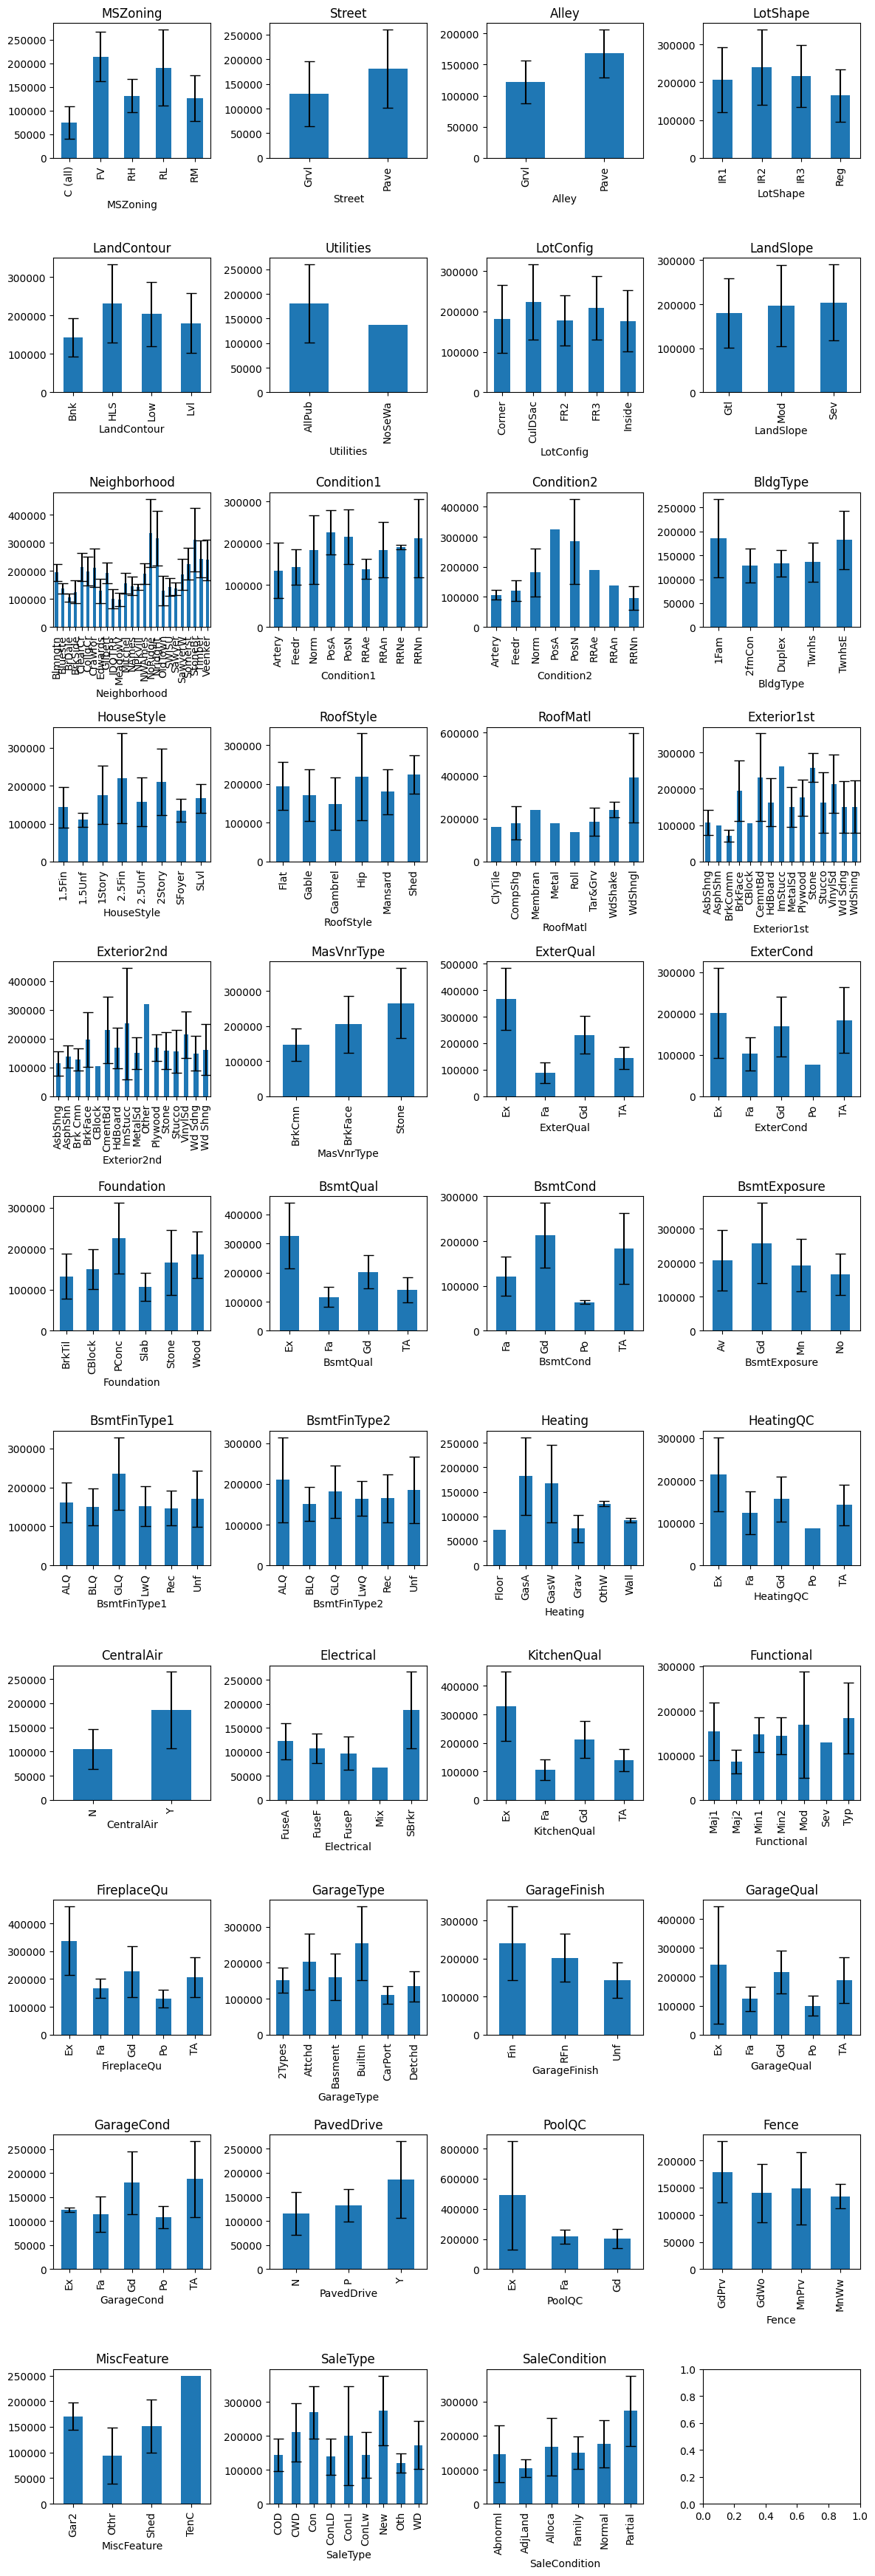

In [27]:
# Finding correlation (indirectly) between 'object' features and target:
plot_mean_price_and_stddev_per_category(train_origin_df)

In [28]:
# Object features that show low correlation to target (by indirect impression):
cat_cols_uncor_w_target = ['LotShape', 'LandContour', 'LotConfig',
                           'LandSlope', 'Condition2', 'RoofMatl', 'BsmtExposure',
                           'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                           'Functional', 'Fence', 'MiscFeature'
                           ]

##### Numerical features with imbalanced data

In [29]:
#numerical features to drop due to high imbalance of the data:
drop_imbalanced = ['Heating', 'Alley', 'Street', 'Utilities']


In [30]:
# filtering the data frame according to selected features to drop:
filtered_df = train_origin_df.drop(high_correlated_features_to_drop, axis=1)
filtered_df = filtered_df.drop(cat_cols_uncor_w_target, axis=1)
filtered_df.drop(drop_imbalanced, axis=1, inplace=True)

##### Feature engineering on pool information + Filling na in LotFrontage

In [31]:
# only 7 samples with pool, but might be important, so:
# we create new *binary* feature 'HavePool' and drop 'PoolQC' 'PoolArea'

# And replacing missing values in 'LotFrontage' with mean values:

filtered_preprocessed_df = preprocess(filtered_df)

#### Understanding The Data

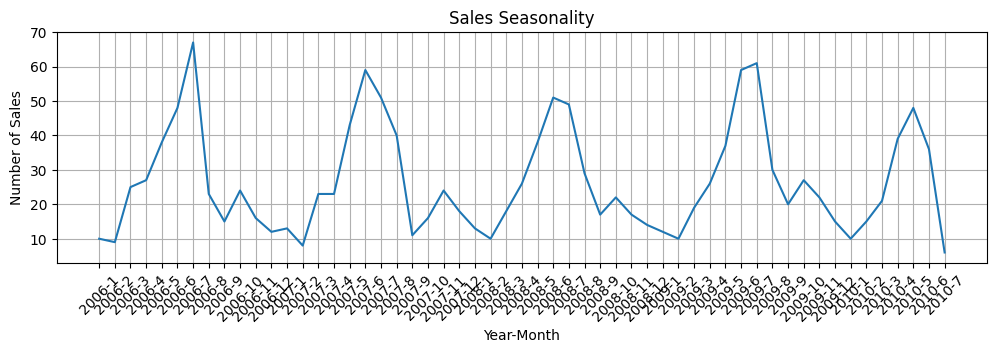

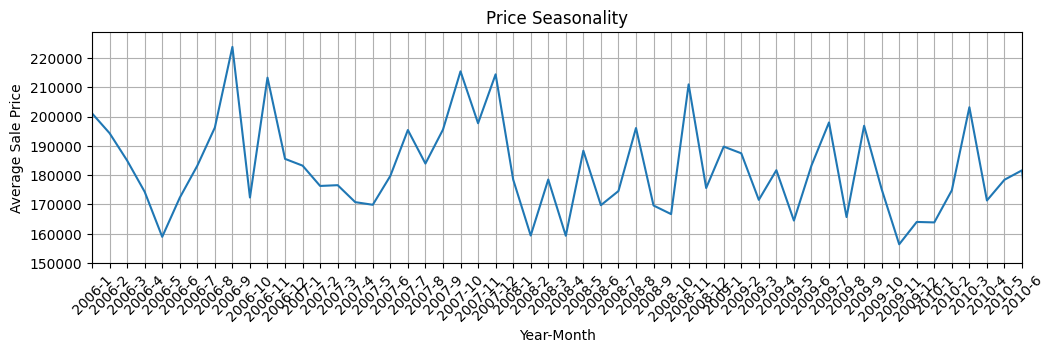

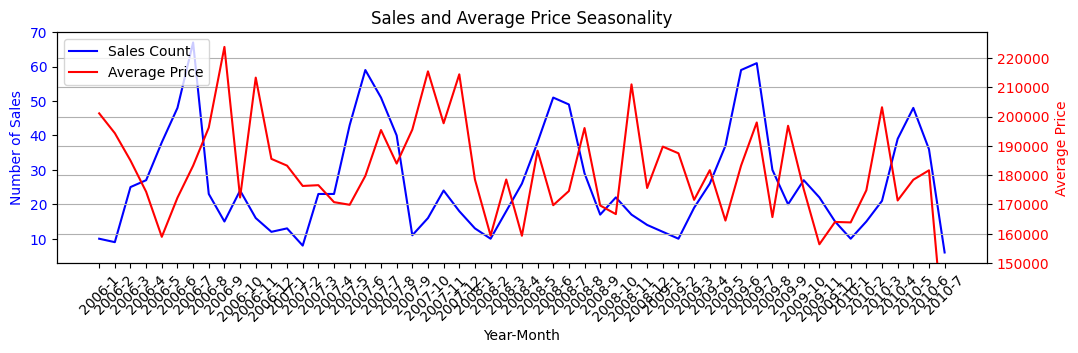

In [32]:
plot_number_of_sales_and_prices_across_time(filtered_preprocessed_df)

The plots above demonstrate pretty clear seasonality in two features: 
* Sales seasonality: we can see a peak in the number of sales on a yearly basis around May-June, followed by a decrease in sales from June to January, with mainly January as the weakest month. 
* Price seasonality: We can see some seasonality in sales prices, albeit less consistent than in the number of sales case. 

Instrestingly, by looking at the combined plot we can see some periods where the number of sales drops down drastically while average price hits a peak. 

## Part 2 - Baseline Model

Todo explain the flow used in the baseline

In [33]:
# This is the configuration used in the baseline:
from flow_config import (get_raw_data_packs,
                         feature_target_separation_packs,
                         preprocessing_packs,
                         labeling_packs,
                         cross_validation_packs,
                         model_grid_search_params)
from sklearn.pipeline import make_pipeline
from model_flow import prepare_submission_csv

get_raw_data_func = get_raw_data_packs['V0']['function']
feature_target_separation_func = feature_target_separation_packs['V0']['function']
baseline_preprocessing_config = preprocessing_packs['V0']
labeling_func = labeling_packs['V0']['function']
cv_splitter_config = cross_validation_packs['TrainTrainTest']  # this splitter essentially does no splitting
cv_splitter = cv_splitter_config['class'](*cv_splitter_config['args'])
baseline_model = model_grid_search_params['LinearRegression']['class']()


# executing baseline
train_raw_data, test_raw_data = get_raw_data_func()

train_X, train_y = feature_target_separation_func(train_raw_data)
test_X, test_y = feature_target_separation_func(test_raw_data)

preprocess_pipe = make_pipeline(*baseline_preprocessing_config['steps'])
preprocess_pipe.fit(train_X)

train_preprocessed_X = preprocess_pipe.transform(train_X)
test_preprocessed_X = preprocess_pipe.transform(test_X)

baseline_model.fit(train_preprocessed_X, train_y)

test_y_pred = baseline_model.predict(test_preprocessed_X)

# if you want to save the file, uncomment this line:
# prepare_submission_csv(test_X.index.values, test_y_pred.flatten())